# Testing rpy2: Princals

We first start with setting up the environment and install the required R and Python packages:

In [ ]:
#!R -e "install.packages(c('mirt', 'Gifi', 'MPsychoR', 'ltm'), repos='https://cran.uni-muenster.de', quiet=TRUE)"
#!pip install rpy2==3.5.17
# Uncomment the line above if you are using Google Colab


R version 4.4.3 (2025-02-28) -- "Trophy Case"
Copyright (C) 2025 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> install.packages(c('mirt', 'Gifi', 'MPsychoR', 'ltm'), repos='https://cran.uni-muenster.de', quiet=TRUE)
also installing the dependencies ‘audio’, ‘globals’, ‘listenv’, ‘R.oo’, ‘R.methodsS3’, ‘permute’, ‘parallelly’, ‘snow’, ‘beepr’, ‘RPushbullet’, ‘future’, ‘future.apply’, ‘progressr’, ‘R.utils’, ‘mvtnorm’, ‘expm’, ‘a

In [ ]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Rpy2 imports
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.packages import importr

# Automatic conversion of arrays and dataframes
pandas2ri.activate()
numpy2ri.activate()

# Set random seed for reproducibility
ro.r('set.seed(123)')

# Ipython extenrsion for magix plotting
%load_ext rpy2.ipython

# R imports
importr('base')
importr('mirt')
importr('Gifi')
importr('MPsychoR')
importr('ltm')




rpy2.robjects.packages.Package as a <module 'ltm'>

## 1. IRT and Factor Analysis

<div style="display: flex; justify-content: space-between;">
  <img src="https://www.researchgate.net/profile/R-Chalmers/publication/275441302/figure/fig1/AS:613924500164609@1523382415156/The-probability-surface-plots-on-the-top-represent-two-dimensional-compensatory-left.png" alt="Multidimensional IRT" style="width: 49%;">
</div>

EFA and CFA are designed for metric input variables
(unless we use specific correlation coefficients suited for categorical data, like tetrachoric correlation). The
main outcomes are factor loadings and factor scores. IRT models are designed for
categorical data with item-category parameters (location, discrimination) and person
parameters as main outcomes. However, it has been found that there is a strong
parametric relationship between FA and IRT (Takane and De Leeuw, 1986).  

Let us consider a simple unidimensional 2-PL, rewritten in logit form:  

(1) $logit(P(X_{vi})) = \alpha_i(\theta_v - \beta_i))$

We can re-parameterize this model as  

(2) $logit(P(X_{vi})) = \alpha_i\theta_v - d_i$

with $d_i = -\beta_i\alpha_i$

The second equation reflects a factor analytic intercept-slope representation of the
2-PL. The discrimination parameter $\alpha_i$ can be interpreted as loading (i.e., slope as
reflected in the ICC plot). The parameter $d_i$ is the intercept. From the first equation,
it follows that $d_i$ = $-\beta_i\alpha_i$ . Note that both equations fit the same model, they are just
parameterized differently. Consequently, the parameters $\theta_i$ are the same, regardless
which expression we use. Within an IRT context (first equation), we call them “person
parameters,” whereas within a FA context (second equation), we call them “factor scores".  

### Fit the models

To illustrate, we conduct a 2-PL analysis which involved
dichotomous items on knowledge characteristics from the WDQ.
We use `ltm` package and request the two different parameterizations.  

Load and inspect the dataset `RWDQ` and remove the first item (first column). Name your subset `RWDQ1`.

In [ ]:
ro.r("data(RWDQ)")

# Convert to Python
RWDQ = pandas2ri.rpy2py(ro.globalenv['RWDQ'])

# Eliminate first item (misfit)
RWDQ1 = RWDQ.drop(RWDQ.columns[0], axis=1)

# Put data into R
ro.globalenv['RWDQ1'] = RWDQ1

Now we fit the two models mentioned above. Try to complete the code for the factor analytic model by setting `IRT.param = FALSE`.

In [ ]:
# Fit the IRT model using lavaan's ltm
ro.r('irtpar <- ltm(RWDQ1 ~ z1)')
ro.r('fapar <- ltm(RWDQ1 ~ z1, IRT.param = FALSE)')

# Combine and compare parameter estimates
compare_params = ro.r('head(cbind(coef(irtpar), coef(fapar)))')

# Print comparison with 3 decimal precision
ro.r('print(round(head(cbind(coef(irtpar), coef(fapar))), 3))')

       Dffclt Dscrmn (Intercept)    z1
wdq_23 -1.064  0.736       0.782 0.736
wdq_24 -0.387  0.822       0.318 0.822
wdq_25 -1.456  1.561       2.273 1.561
wdq_26 -2.113  0.668       1.412 0.668
wdq_27 -0.570  1.157       0.659 1.157
wdq_28 -1.138  0.808       0.919 0.808


The first two columns are based on the parameterization in Eq. (1), involving
$\alpha_i$ and $\beta_i$ . The last two columns correspond to $d_i$ and $\alpha_i$ from Eq. (2).   
Let us compute the person parameters and confirm that they are the same for both models.

In theory, both set of person parameters should be the same. To investigate if this is true, use the `identical` function.

In [ ]:
ro.r("irtppar <- factor.scores(irtpar)$score.dat$z1")
ro.r("fappar <- factor.scores(fapar)$score.dat$z1")

print(ro.r("identical(irtppar, fappar)"))

[1] TRUE



As indicated by the `identical` function, the two scores are in fact the same.  

Besides IRT and Factor Analysis there is also Item Factor Analysis (IFA).
IFA marries IRT and FA so that we get the best of both worlds: On the one hand,
we have all the possibilities exploratory/confirmatory model specification, good
opportunities for goodness-of-fit assessment, and options for rotation from the FA
world. On the other hand, we can make use of the wide range of developed IRT
models and get a deep probabilistic insight into the behavior of items and persons.
Note that the terms “MIRT” and “IFA” are often used synonymously. Here, from now on, we use “MIRT.”

## 2. Exploratory Multidimensional IRT

The `mirt` package allows us to fit all dichotomous and polytomous IRT models
presented above in a multidimensional exploratory or confirmatory fashion. The
main function is `mirt()`. Through the `itemtype` argument, a particular IRT model
can be specified. In this section, we focus on exploratory specifications, that is,
*each item is free to load on each factor*.  

### Fit the models
![ ](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTtqJvy8zcvFg_uUDxsTPuDcOSlOiGQcgNnEw&s)

Let us illustrate an exploratory multidimensional 2-PL model fit using all binary
ZAREKI addition and subtraction items described in Sect. 4.2.1. First, we compute
an exploratory Princals in order to get an idea of the structure and dimensionality.  

Load the dataset `zareki` and inspect it. Then, extract the first 16 columns, name this subset `itzareki`. Next, fit the model using the `princals` function, name it `przar`.

In [ ]:
ro.r('data("zareki")')
# Convert to Python
zareki = pandas2ri.rpy2py(ro.globalenv['zareki'])

# Eliminate first item (misfit)
itzareki = zareki.loc[:, zareki.columns[:16]]
print(itzareki.head())

# Put data into R
ro.globalenv['itzareki'] = itzareki

# Fit the model
ro.r("przar <- princals(itzareki)")

   addit1  addit2  addit3  addit4  addit5  addit6  addit7  addit8  subtr1  \
1     1.0     1.0     1.0     1.0     1.0     1.0     1.0     0.0     1.0   
2     1.0     1.0     1.0     1.0     0.0     1.0     1.0     0.0     1.0   
3     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
4     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
5     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

   subtr2  subtr3  subtr4  subtr5  subtr6  subtr7  subtr8  
1     1.0     1.0     1.0     1.0     1.0     0.0     1.0  
2     1.0     1.0     1.0     1.0     1.0     0.0     1.0  
3     1.0     0.0     1.0     1.0     0.0     0.0     1.0  
4     1.0     0.0     1.0     1.0     0.0     1.0     1.0  
5     1.0     0.0     1.0     1.0     0.0     0.0     1.0  


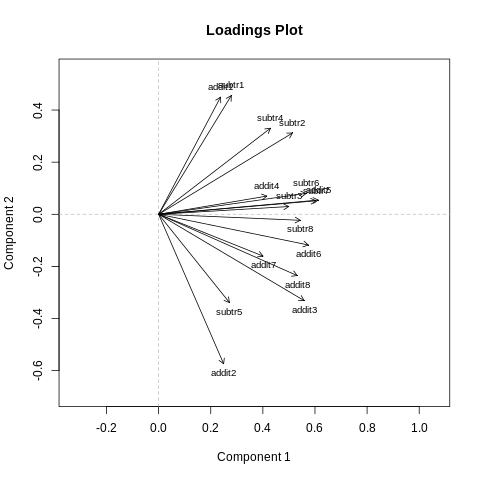

In [ ]:
%%R
plot(przar)


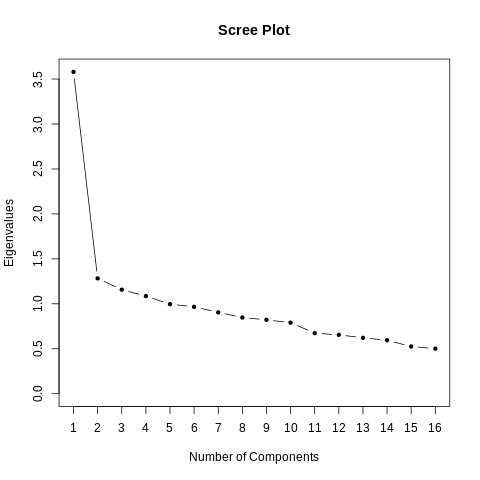

In [ ]:
%%R
plot(przar, "screeplot")

The scree plot suggests that two dimensions should be
sufficient. From the loadings plot in the left panel, we see that the dimensions are
not addition vs. subtraction, as we might have expected.
Let us fit two models: a unidimensional 2-PL and a two-dimensional 2-PL.
Note that we use a 2-PL model as the data is dichotomous. If we would want to apply the `mirt()` function to a polytomous dataset we could for example use a graded response model by setting the `itemtype` argument to `'graded'` (see below).  

Fit one 1D model and one 2D model using the `mirt` function and the extracted subset. Note the we want to fit 2-PL model, therefore we should set `itemtype = "2PL` Remember the syntax? If not, check the hint! Name your models `zar1d` and `zar2d`.

In [ ]:
ro.r('zar1d <- mirt(itzareki, 1, itemtype = "2PL")')
ro.r('zar2d <- mirt(itzareki, 2, itemtype = "2PL")')

Iteration: 20, Log-Lik: -2252.281, Max-Change: 0.00008
Iteration: 133, Log-Lik: -2235.476, Max-Change: 0.00010


### Compare and investigate the models

Use the `anova` function to compare the two models.

In [ ]:
print(ro.r('anova(zar1d, zar2d)'))

           AIC    SABIC       HQ      BIC    logLik    X2 df     p
zar1d 4568.562 4589.671 4617.415 4691.182 -2252.281               
zar2d 4564.952 4595.957 4636.706 4745.051 -2235.476 33.61 15 0.004



For further fit examination of the 1D and the 2D model, let us compute the M2 statistic
including the CFA/SEM fit indices.

In [ ]:
print(ro.r("M2(zar1d)"))
print(ro.r("M2(zar2d)"))

           M2  df          p      RMSEA     RMSEA_5   RMSEA_95      SRMSR
stats 129.675 104 0.04483401 0.02694632 0.004455123 0.04072114 0.05232611
            TLI       CFI
stats 0.9757999 0.9790266

            M2 df         p RMSEA RMSEA_5   RMSEA_95      SRMSR       TLI
stats 94.11394 89 0.3350678 0.013       0 0.03274862 0.04382372 0.9943675
            CFI
stats 0.9958225



The output of the 1D model suggest slight misfit (significant M2 p-value) and some criteria (e.g. TLI and CFI) suggest a worse fit of the 1D model *compared to the 2D model*.
For the 2D model, we get a low RMSEA and a high CFI, and the M2 p-value is not significant. The 2D model **fits well**. Note that the 1D model does not provide a bad fit but we can assume that the 2D model provides a slightly better fit, therefore we continue using the 2D model.
Itemfit statistics can be computed using the corresponding function in `mirt`.  

Let us still search for potentially bad fitting items. For that, lets first print out itemfit statistics using `mirt::itemfit`.
The function only uses the model object as an input. Remember, we want to investigate the 2D model (`zar2d`). Assign the output to `ifit2D2pl`.

In [ ]:
ro.r("ifit2D2pl <- mirt::itemfit(zar2d)")
# Convert to Python
ifit2D2pl = pandas2ri.rpy2py(ro.globalenv['ifit2D2pl'])

ifit2D2pl.head()

,item,S_X2,df.S_X2,RMSEA.S_X2,p.S_X2
1,addit1,1.588226,6.0,0.000000,0.953420
2,addit2,15.986000,8.0,0.054185,0.042581
3,addit3,7.655657,7.0,0.016598,0.363934
4,addit4,5.685148,7.0,0.000000,0.576955
5,addit5,6.581252,7.0,0.000000,0.473740


As we don't want to go through all items manually, lets do this in a clever way. Look at the output from the `head` function, notice the p.S_X2? Lets use this p-value (column 4 of `ifit2D2pl`) as a cut-off. If an item has a significant (p < .05) S_X2 value we should take a closer look at it. Think about how to you can print the items (rows) of the `ifit2D2pl` object which have a p-value (column 5) smaller than .05.

In [ ]:
misfitting_items = ifit2D2pl[ifit2D2pl.iloc[:, 4] < 0.05]
print(misfitting_items)

      item       S_X2  df.S_X2  RMSEA.S_X2    p.S_X2
2   addit2  15.986000      8.0    0.054185  0.042581
12  subtr4  20.871019      8.0    0.068789  0.007498


The subtr4 item and the subtr2 could be eliminated since they show some misfit, and then the
model needs to be refitted again. However, since the global model fit suggested a
well-fitting solution, let us keep them.  

The factor analytic parameterization can be obtained through the summary call.
We can also request to apply an orthogonal or non-orthogonal rotation for better
interpretability.

In [ ]:
print(ro.r("summary(zar2d, rotate = 'varimax')"))
print(ro.r("summary(zar2d, rotate = 'oblimin')"))


Rotation:  varimax 

Rotated factor loadings: 

           F1     F2    h2
addit1 0.4128 0.2238 0.220
addit2 0.0114 0.5467 0.299
addit3 0.2524 0.7828 0.677
addit4 0.4719 0.4551 0.430
addit5 0.5499 0.4741 0.527
addit6 0.2206 0.6760 0.506
addit7 0.2945 0.3930 0.241
addit8 0.1309 0.7139 0.527
subtr1 0.5203 0.1779 0.302
subtr2 0.9047 0.0903 0.827
subtr3 0.4172 0.4279 0.357
subtr4 0.4412 0.3204 0.297
subtr5 0.2362 0.2261 0.107
subtr6 0.5291 0.3940 0.435
subtr7 0.5490 0.4833 0.535
subtr8 0.5142 0.4090 0.432

Rotated SS loadings:  3.271 3.448 

Factor correlations: 

   F1 F2
F1  1   
F2  0  1
None

Rotation:  oblimin 

Rotated factor loadings: 

            F1      F2    h2
addit1  0.3784  0.1509 0.220
addit2 -0.1638  0.6057 0.299
addit3  0.0232  0.8112 0.677
addit4  0.3684  0.3943 0.430
addit5  0.4474  0.3969 0.527
addit6  0.0229  0.6998 0.506
addit7  0.1948  0.3673 0.241
addit8 -0.0872  0.7634 0.527
subtr1  0.5106  0.0742 0.302
subtr2  0.9584 -0.1147 0.827
subtr3  0.3174  0.3770 0.357
sub

### Plot results

The `mirt` package provides several plotting options for two-dimensional models. Lets plot the Item characteristic
surface (ICS) for the 3rd item in 2D. For that, use the `itemplot` function. It takes the model (`zar2d`), the item (3) and a list of rotation coordinates as inputs. The latter is already specified, you only need to complete the remaining 2 arguments. Note: `main = "ICS addit3"` sets the title of the plot.

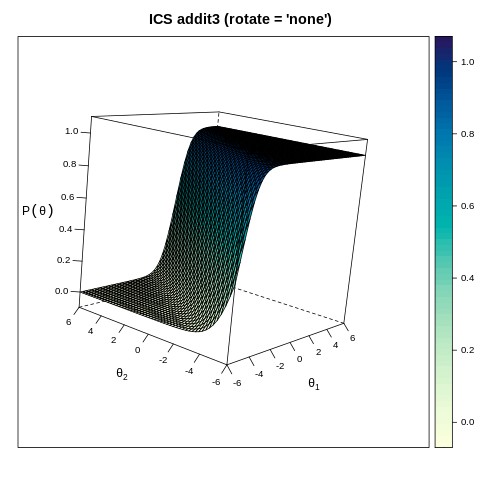

In [ ]:
%%R
itemplot(zar2d, 3, main = "ICS addit3", rot = list(xaxis = -70, yaxis = 50, zaxis = 10))

### Compute person scores, one for each dimension

Finally, we can compute the person parameters, one for each dimension (only
first six persons shown here).

In [ ]:
ro.r("fscores(zar2d)")

array([[ 0.31629087,  0.08593608],
       [-0.13045086, -0.26424651],
       [-0.31739614,  0.07663827],
       [ 0.12578337,  0.45310387],
       [-0.31739614,  0.07663827],
       [-0.43184699, -0.89689762],
       [ 0.07289139,  0.35176114],
       [-1.23422604, -2.06142719],
       [-1.48519979, -0.09390775],
       [-2.20962536, -2.5090477 ],
       [ 0.10344465,  0.06438149],
       [ 0.55527341,  0.85361562],
       [-0.76972592, -1.50475692],
       [-0.4801597 , -0.51822168],
       [ 0.72721598,  0.52640777],
       [-1.2854217 , -1.59494078],
       [-1.67145428, -0.71656631],
       [-1.79202968, -1.27932313],
       [ 0.56545172,  0.76491233],
       [-2.49302421, -2.77576318],
       [-0.69890551, -1.05061595],
       [-0.21921476, -1.28373925],
       [-1.63795304, -2.83945932],
       [-0.92519626, -1.78262542],
       [-1.68028061, -1.08794529],
       [-2.09102447, -2.0604506 ],
       [-0.30693942, -1.12662113],
       [-0.1059822 ,  0.11204094],
       [-0.33548998,

## 3. Confirmatory Multidimensional IRT

In this section, we illustrate how MIRT models can be fitted in a confirmatory way.
As in CFA, we assign items to load on a particular dimension. We use once more
the *polytomous* ASTI dataset and assign the items to the following five
factors, based on the underlying ASTI theory: self-knowledge and integration (**si**),
peace of mind (**pm**), non-attachment (**na**), self-transcendence (**st**), and presence
in the here-and-now and growth (pg), as described in Koller et al. (2017). We fit a
multidimensional GRM (5 dimensions).

### Fit the model

Note that the `mirt` model specification syntax is a bit different from `lavaan`.
Below we specify the item assignments to the factors and the corresponding
covariance structure of the latent variables (we allow for a full correlation pattern).  

Load and inspect the `ASTI` dataset. Next, extract a subset that contains all rows but only the first 25 (1:25) columns of `ASTI`. Name the subset `itasti`.  

The model has already been specified for you. You only need to fit it. To do that, use the `mirt` function, providing the following inputs: the `data` (`itasti`), the `model` (`modASTI`), the `itemtype` (you can leave the other inputs as they are). As we use *polytomous* data we have to set the this argument to `graded`.

In [ ]:
ro.r('data("ASTI")')
# Convert to Python
ASTI = pandas2ri.rpy2py(ro.globalenv['ASTI'])

# Eliminate first item (misfit)
itasti = ASTI.loc[:, ASTI.columns[:25]]
print(itasti.head())

# Put data into R
ro.globalenv['itasti'] = itasti

# Specifiy the model
ro.r('modASTI <- "'
      'si = 10,19,20,21\n'
      'pm = 1,5,9,22\n'
      'na = 3,6,8,12\n'
      'st = 2,4,7,13,16,24,25\n'
      'pg = 11,14,15,17,18,23\n'
      'COV = si*pm*na*st*pg"')

#fit the model
ro.r("asti5d <- mirt(itasti, model = modASTI, itemtype = 'graded', method = 'MHRM', SE.type = 'MHRM', verbose = FALSE)")

   ASTI1  ASTI2  ASTI3  ASTI4  ASTI5  ASTI6  ASTI7  ASTI8  ASTI9  ASTI10  ...  \
1    1.0    2.0    2.0    3.0    3.0    1.0    2.0    1.0    3.0     2.0  ...   
2    2.0    2.0    3.0    2.0    3.0    1.0    2.0    1.0    3.0     2.0  ...   
3    1.0    1.0    0.0    1.0    2.0    1.0    0.0    2.0    2.0     1.0  ...   
4    1.0    2.0    2.0    3.0    1.0    2.0    2.0    2.0    1.0     1.0  ...   
5    2.0    3.0    2.0    3.0    1.0    1.0    3.0    1.0    3.0     1.0  ...   

   ASTI16  ASTI17  ASTI18  ASTI19  ASTI20  ASTI21  ASTI22  ASTI23  ASTI24  \
1     3.0     0.0     1.0     1.0     0.0     1.0     1.0     2.0     0.0   
2     2.0     2.0     2.0     1.0     2.0     1.0     1.0     1.0     1.0   
3     1.0     2.0     2.0     2.0     1.0     0.0     2.0     2.0     1.0   
4     3.0     0.0     3.0     2.0     1.0     1.0     1.0     2.0     0.0   
5     3.0     1.0     2.0     2.0     0.0     0.0     2.0     2.0     1.0   

   ASTI25  
1     2.0  
2     1.0  
3     2.0  
4 

Compared to the 2D-2PL from above, here we use a different estimation
algorithm which is suggested to employ for higher-dimensional models.
First, we print out correlation matrix of the trait dimensions. Second, from the
loadings in `astisum$rotF`, we see that item 18 (“I often lose myself in what I
am doing”) has a very small loading on the personal growth dimension and could
therefore be subject to elimination. Run the following code chunk.

### Inspect the model

In [ ]:
ro.r("astisum <- summary(asti5d, verbose = FALSE)")
print(ro.r("round(astisum$fcor, 3)")) # Correlation matrix

print(ro.r('round(astisum$rotF["ASTI18",], 4)')) # Loadings of item ASTI18

[[1.    0.712 0.232 0.122 0.838]
 [0.712 1.    0.547 0.166 0.77 ]
 [0.232 0.547 1.    0.139 0.196]
 [0.122 0.166 0.139 1.    0.336]
 [0.838 0.77  0.196 0.336 1.   ]]
[ 0.      0.      0.      0.     -0.0074]


### Inspect model fit

Again, let us compute the M2 statistic, including the CFA/SEM fit indices.
Run the following code chunk.

In [ ]:
print(ro.r("M2(asti5d, QMC = TRUE)"))

Exception ignored from cffi callback <function _processevents at 0x79cec146d620>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/rpy2/rinterface_lib/callbacks.py", line 283, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
    
KeyboardInterrupt: 


            M2  df p      RMSEA    RMSEA_5   RMSEA_95      SRMSR       TLI
stats 907.4895 228 0 0.05140074 0.04789892 0.05490454 0.06055476 0.8187901
            CFI
stats 0.8429055



The global fit indices and model test suggest a poor model fit.  

For such complex scenarios, an exploratory version of the model with oblique
rotation would give us the possibility to explore in more detail what is going
on. Another good strategy, before even considering fitting a confirmatory MIRT
model, is to compute unidimensional models for each subscale individually and
eliminate misfitting items already at that level. The items kept in the model can be
subsequently subject to a higher-dimensional IRT fit.

### End of todays session

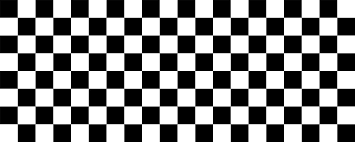 \

Congrats! You have now finished the RMD on Multidimensional IRT. If you have any question that we did not cover in class, feel free to either post it on the forum section or to come to our open office ours on Wednesday 10-11 a.m. and/or Friday 01-02 p.m.